# Import libraries

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import datetime
import os
import numpy as np
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
# import shap

In [2]:
warnings.filterwarnings("ignore")

# Data Import

In [3]:
# # Get the current working directory
# current_dir = os.getcwd()
# # Move up one level from the current directory
# parent_dir = os.path.dirname(current_dir)
# df = pd.read_csv(os.path.join(parent_dir, 'dataset', 'clean_data.csv'))

In [5]:
# Get the current working directory
current_dir = os.getcwd()
# Move up one level from the current directory
parent_dir = os.path.dirname(current_dir)

key_df = pd.read_csv(os.path.join(parent_dir, 'british-airway-user.csv'), index_col=None)

In [7]:
import boto3
import pandas as pd
from io import StringIO

# Initialize a session using Amazon S3
s3_client = boto3.client('s3', aws_access_key_id=key_df['Access key ID'][0], aws_secret_access_key=key_df['Secret access key'][0])

# Name of the S3 bucket
bucket_name = 'british-airway'

# Function to get the two most recent CSV files
def get_recent_csv_files(bucket_name, num_files=2):
    csv_files = []
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    for obj in response.get('Contents', []):
        if obj['Key'].endswith('.csv'):
            csv_files.append({'Key': obj['Key'], 'LastModified': obj['LastModified']})
    
    # Sort the files by last modified date in descending order and get the top 'num_files' entries
    recent_csv_files = sorted(csv_files, key=lambda x: x['LastModified'], reverse=True)[:num_files]
    return [file['Key'] for file in recent_csv_files]

# Function to read a CSV file from S3 into a DataFrame
def read_csv_to_df(bucket_name, file_key):
    csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string))
    return df

# Get the two most recent CSV files

recent_csv_files = get_recent_csv_files(bucket_name)

# You can now loop through the file keys or handle them individually
# Example: Read the files into DataFrames
dataframes = [read_csv_to_df(bucket_name, file_key) for file_key in recent_csv_files]

df= dataframes[0]
previous_df= dataframes[1]

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
new_column_names = {'Dates Review': 'date_review',
                    'Day Review': 'day_review',
                    'Month Review': 'month_review',
                   'Month Review Number': 'month_review_num',
                   'Year Review': 'year_review',
                   'Verified': 'verified',
                   'Customer Name':'name',
                   'Month Flown': 'month_fly',
                   'Month Flown Number': 'month_fly_num',
                    'Year Flown':'year_fly',
                   'Month Year Flown': 'month_year_fly',
                   'Country': 'country',
                   'Aircraft': 'aircraft',
                   'Type Of Traveller': 'type',
                   'Seat Type': 'seat_type',
                   'Route': 'route',
                   'Seat Comfort': 'seat_comfort',
                   'Cabin Staff Service': 'cabit_serv',
                   'Food & Beverages': 'food',
                   'Ground Service': 'ground_service',
                   'Wifi & Connectivity': 'wifi',
                   'Value For Money': 'money_value',
                   'Recommended': 'recommended',
                   'Review': 'review'}

df.rename(columns=new_column_names, inplace=True)

In [10]:
df = df.drop(columns=['month_fly', 'month_fly_num','year_fly', 'day_review', 'month_review', 'month_review_num', 'year_review'])

In [11]:
df.columns

Index(['id', 'date_review', 'verified', 'verified.1', 'name', 'month_year_fly',
       'country', 'aircraft', 'aircraft_1', 'aircraft_2', 'type', 'seat_type',
       'route', 'origin', 'destination', 'transit', 'seat_comfort',
       'cabit_serv', 'food', 'ground_service', 'wifi', 'money_value', 'score',
       'experience', 'recommended', 'review'],
      dtype='object')

In [12]:
df.dtypes

id                  int64
date_review        object
verified             bool
verified.1           bool
name               object
month_year_fly     object
country            object
aircraft           object
aircraft_1         object
aircraft_2         object
type               object
seat_type          object
route              object
origin             object
destination        object
transit            object
seat_comfort      float64
cabit_serv        float64
food              float64
ground_service    float64
wifi              float64
money_value         int64
score             float64
experience         object
recommended          bool
review             object
dtype: object

In [13]:
df['recommended'] = df['recommended'].replace({'yes': 1, 'no': 0})
df['verified'] = df['verified'].astype('str')
df['verified'] = df['verified'].replace({'True': 1, 'False': 0})

In [14]:
df['aircraft'].fillna(0, inplace=True)
df['wifi'].fillna(0, inplace=True)
df['aircraft'] = df['aircraft'].apply(lambda x: 1 if x != 0 else 0)
df['wifi'] = df['wifi'].apply(lambda x: 1 if x != 0 else 0)

In [15]:
#df['date_review'] = df['date_review'].astype('datetime64[ns]')
#df['month_year_fly'] = df['month_year_fly'].astype('datetime64[ns]')
df['seat_comfort'] = pd.to_numeric(df['seat_comfort'], errors='coerce').astype('Int64')
df['cabit_serv'] = pd.to_numeric(df['cabit_serv'], errors='coerce').astype('Int64')
df['food'] = pd.to_numeric(df['food'], errors='coerce').astype('Int64')
df['ground_service'] = pd.to_numeric(df['ground_service'], errors='coerce').astype('Int64')

In [16]:
df.head(3)

,id,date_review,verified,verified.1,name,month_year_fly,country,aircraft,aircraft_1,aircraft_2,type,seat_type,route,origin,destination,transit,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,score,experience,recommended,review
0,0,2024-04-12,1,True,Eelco van den Heuvel,03-2024,Netherlands,1,A319,E190,Couple Leisure,Economy Class,Rotterdam to London City,Rotterdam,London City,NaN,3,3,3,3,0,2,3.000000,Poor,False,We chose Rotterdam and London City airport bec...
1,1,2024-04-10,0,False,Jacki Dioguardi,01-2024,United States,0,NaN,NaN,Family Leisure,Economy Class,Tenerife to London,Tenerife,London,NaN,<NA>,<NA>,<NA>,1,0,1,1.000000,Poor,False,British Airways cancelled my flight less than ...
2,2,2024-04-10,1,True,J Davidson,04-2024,United States,0,NaN,NaN,Solo Leisure,Premium Economy,Kansas City to Dublin via Heathrow,Kansas City,Dublin,London Heathrow,2,3,<NA>,3,0,1,2.666667,Poor,False,The entire booking and ticketing experience ha...


# Null Handling using KNN

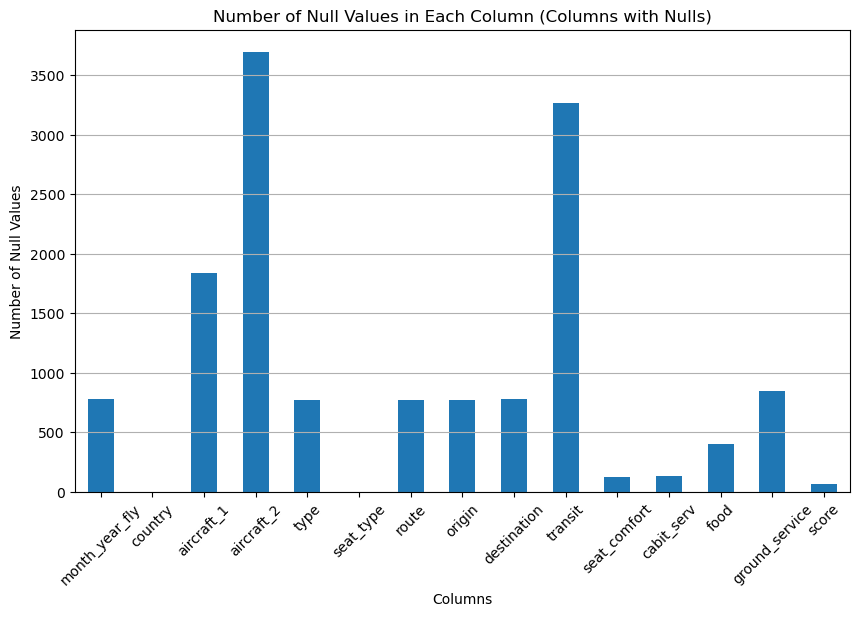

In [17]:
null_counts = df.isnull().sum()

null_counts_filtered = null_counts[null_counts > 0]

null_counts_filtered.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Null Values in Each Column (Columns with Nulls)')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45)  
plt.grid(axis='y')  
plt.show()

In [18]:
df.seat_comfort

0          3
1       <NA>
2          2
3          3
4          3
        ... 
3780       2
3781       4
3782    <NA>
3783       1
3784       4
Name: seat_comfort, Length: 3785, dtype: Int64

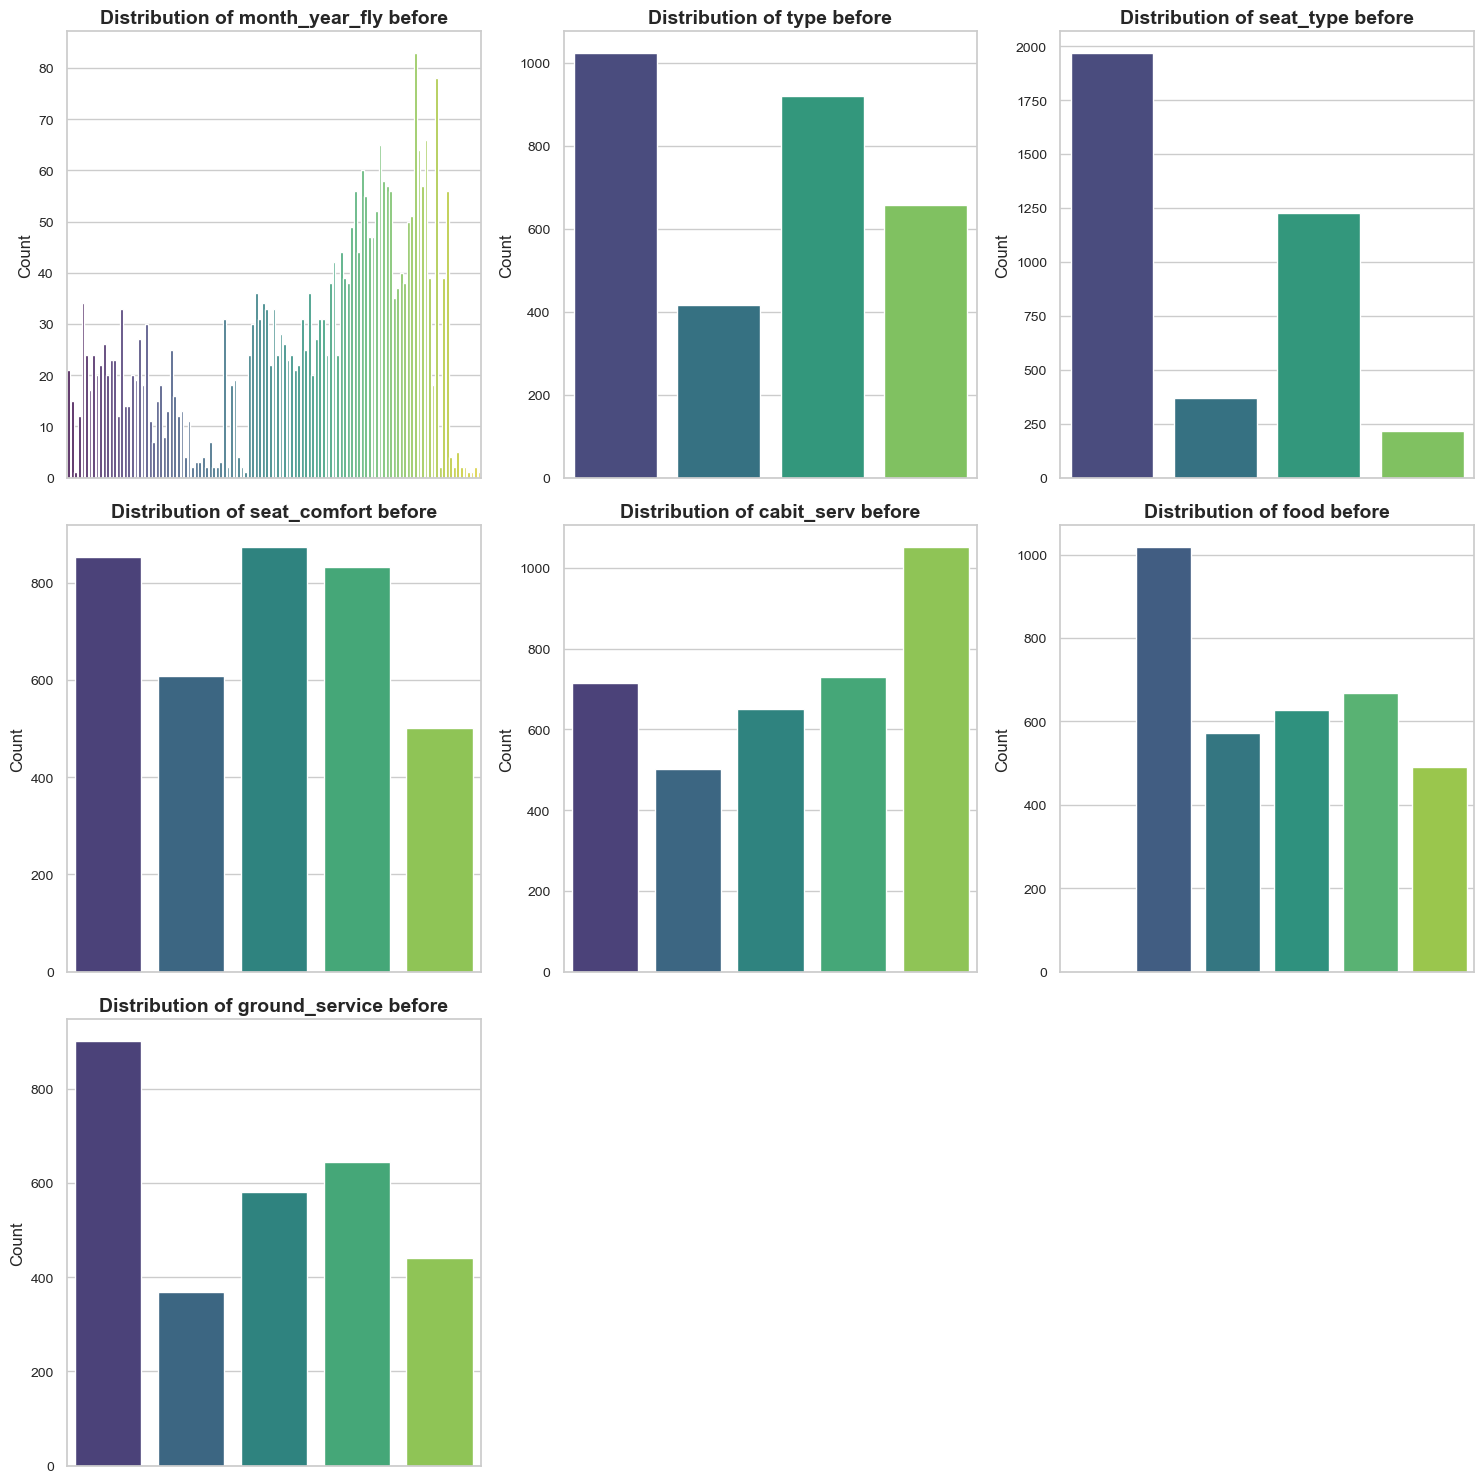

In [19]:
# Assuming df is your DataFrame containing the data

categorical_columns = ['month_year_fly', 'type', 'seat_type', 'seat_comfort',
                        'cabit_serv', 'food', 'ground_service']
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    
    # Handle NaN values in the current column
    column_values = df[column].dropna()
    
    # Plot count distribution
    sns.countplot(x=column_values, palette="viridis")
    
    plt.title(f'Distribution of {column} before', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

plt.show()

In [20]:
# Handling 'seat_comfort', 'cabit_serv', 'food', 'ground_service'
columns_with_missing = ['seat_comfort', 'cabit_serv', 'food', 'ground_service']
imputer = KNNImputer(n_neighbors=5)
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

In [21]:
review_columns = ['seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']
df[review_columns] = df[review_columns].round()

In [22]:
# Handling 'country' and 'seat_type' NAs
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['seat_type'].fillna(df['seat_type'].mode()[0], inplace = True)

In [23]:
# Handling 'type' NAs
df_known_type = df[df['type'].notna()]
df_missing_type = df[df['type'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_type[features], df_known_type['type'])

predicted_type = rf_classifier.predict(df_missing_type[features])
df.loc[df['type'].isna(), 'type'] = predicted_type

In [24]:
# Handling 'route' NAs
df_known_route = df[df['route'].notna()]
df_missing_route = df[df['route'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_route[features], df_known_route['route'])

predicted_route = rf_classifier.predict(df_missing_route[features])
df.loc[df['route'].isna(), 'route'] = predicted_route

In [25]:
# Handling 'month_year_fly' NAs
df_known_time = df[df['month_year_fly'].notna()]
df_missing_time = df[df['month_year_fly'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_time[features], df_known_time['month_year_fly'])

predicted_time = rf_classifier.predict(df_missing_time[features])
df.loc[df['month_year_fly'].isna(), 'month_year_fly'] = predicted_time

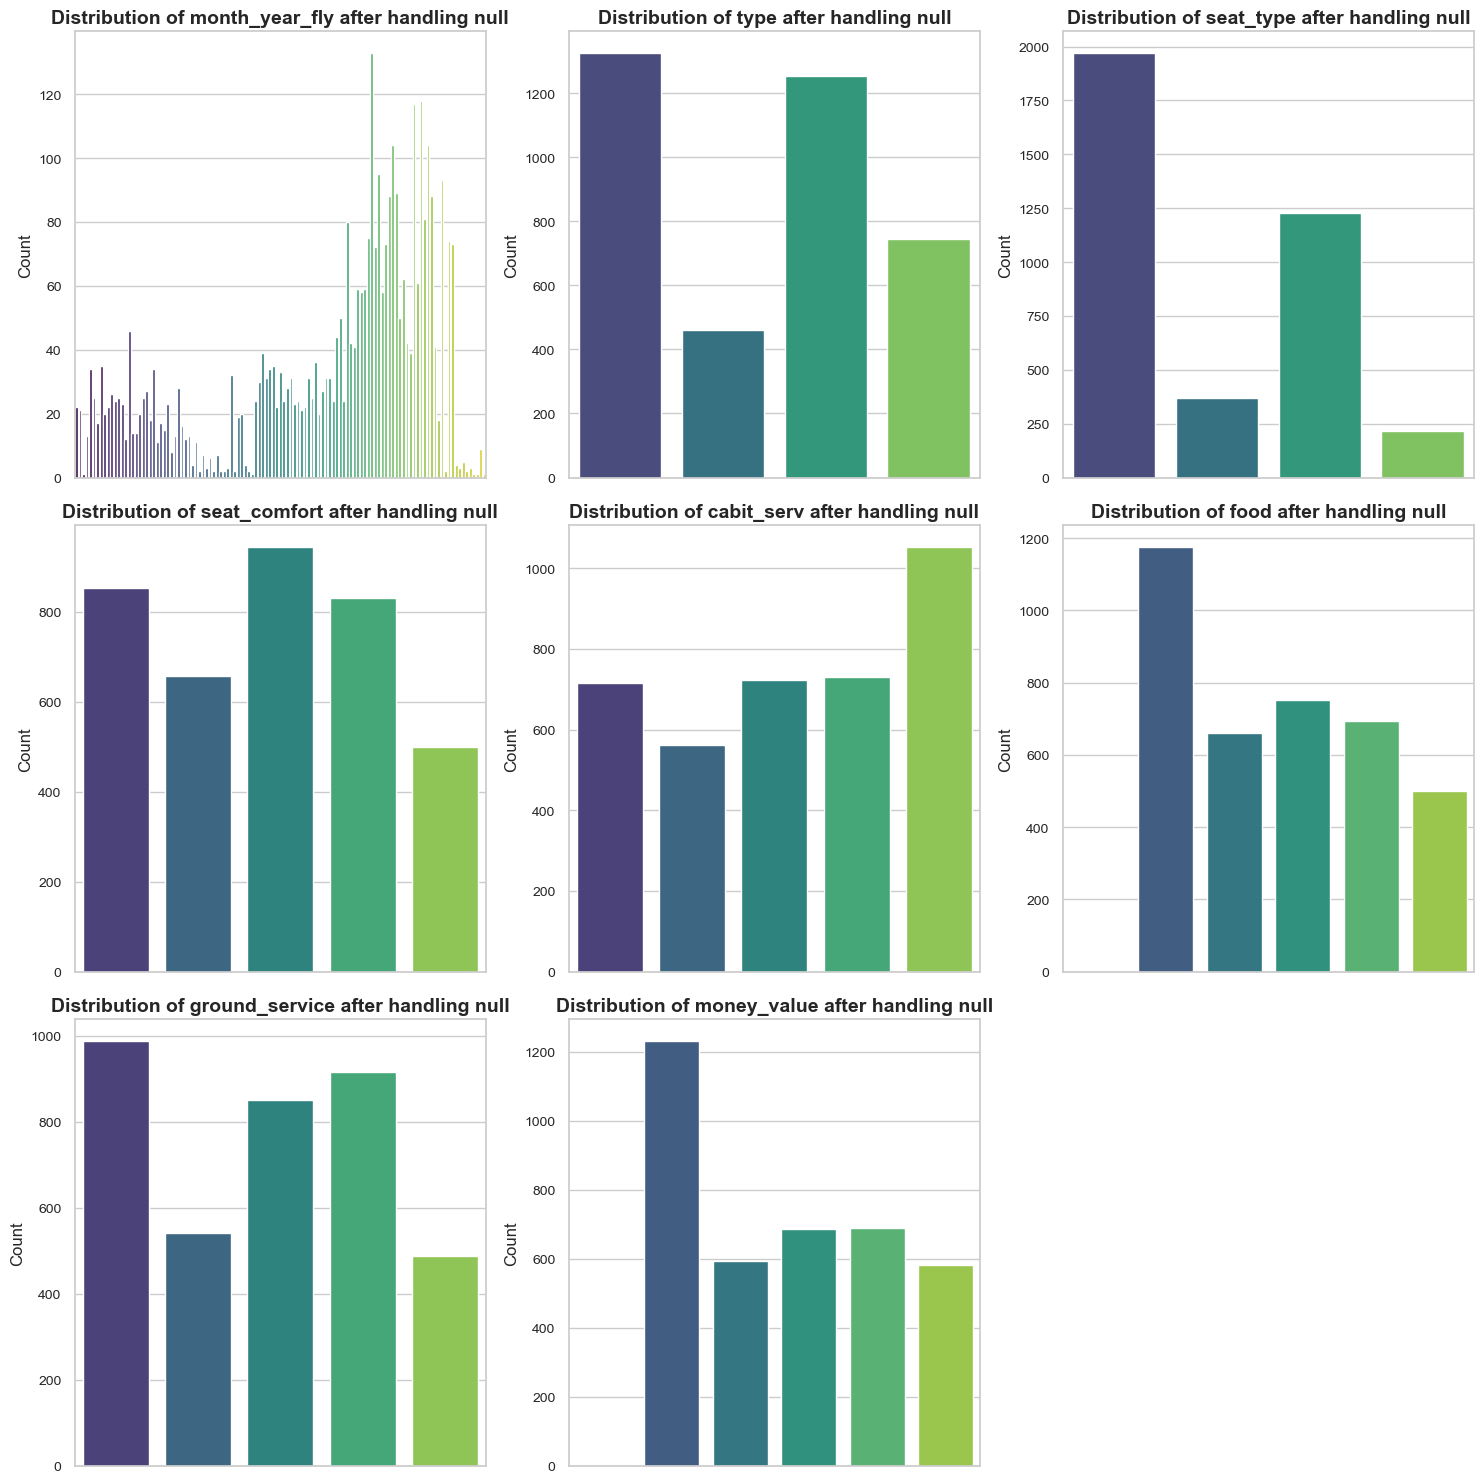

In [27]:
categorical_columns = ['month_year_fly', 'type', 'seat_type', 
                       'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'money_value']
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.countplot(data=df, x=column, palette="viridis")
    plt.title(f'Distribution of {column} after handling null', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3785 non-null   int64  
 1   date_review     3785 non-null   object 
 2   verified        3785 non-null   int64  
 3   verified.1      3785 non-null   bool   
 4   name            3785 non-null   object 
 5   month_year_fly  3785 non-null   object 
 6   country         3785 non-null   object 
 7   aircraft        3785 non-null   int64  
 8   aircraft_1      1944 non-null   object 
 9   aircraft_2      87 non-null     object 
 10  type            3785 non-null   object 
 11  seat_type       3785 non-null   object 
 12  route           3785 non-null   object 
 13  origin          3010 non-null   object 
 14  destination     3008 non-null   object 
 15  transit         520 non-null    object 
 16  seat_comfort    3785 non-null   float64
 17  cabit_serv      3785 non-null   f

# Feature Engineering

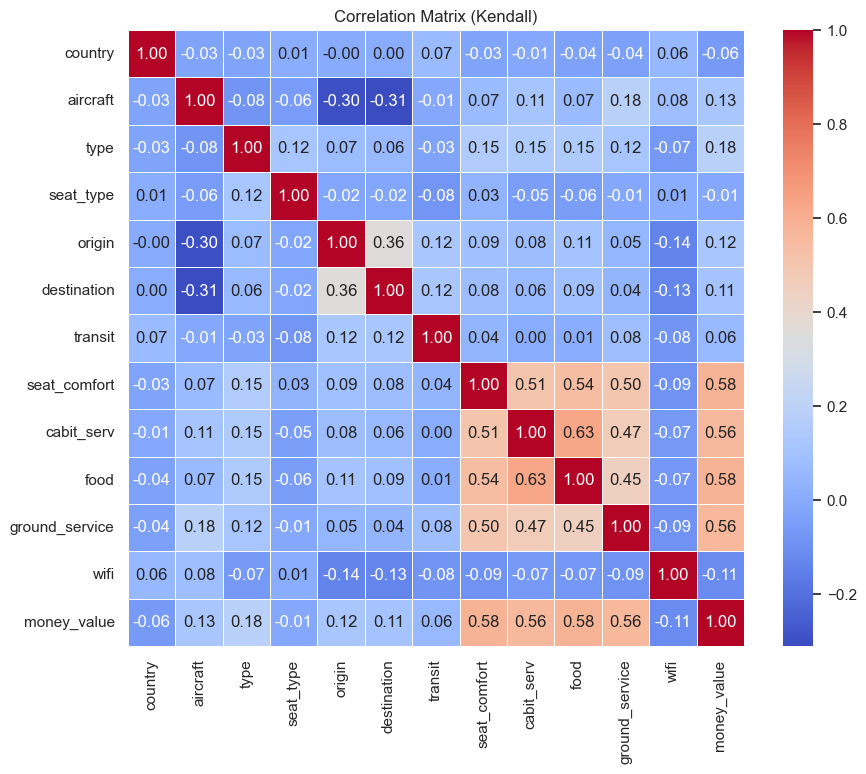

In [29]:
explanatory_vars = ['country', 'aircraft', 'type', 'seat_type', 'origin', 'destination', 'transit' , 'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']

label_encoder = LabelEncoder()
for var in explanatory_vars:
    df[var] = label_encoder.fit_transform(df[var])

correlation_matrix = df[explanatory_vars + ['money_value']].corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix (Kendall)')
plt.show()

In [30]:
# Filter correlation pairs for money_value and sort
money_value_correlations = correlation_matrix['money_value'].sort_values(ascending=False)
money_value_correlations = money_value_correlations[money_value_correlations.index != 'money_value']
print(money_value_correlations)

seat_comfort      0.584317
food              0.583024
ground_service    0.560118
cabit_serv        0.557002
type              0.182361
aircraft          0.127660
origin            0.121543
destination       0.105540
transit           0.061670
seat_type        -0.010615
country          -0.062653
wifi             -0.111824
Name: money_value, dtype: float64


In [31]:
def calculate_tree_importance(X, y):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    tree_importance = rf_model.feature_importances_
    tree_sorted_idx = np.argsort(tree_importance)[::-1]
    sorted_feature_names = X.columns[tree_sorted_idx]
    sorted_importances = tree_importance[tree_sorted_idx]
    
    plt.figure(figsize=(11.7, 8.27))
    sns.barplot(x=sorted_importances, y=sorted_feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Tree-based Feature Importance')
    plt.show()
    
    return tree_sorted_idx

In [32]:
def calculate_permutation_importance(X, y):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
    
    plt.figure(figsize=(11.7, 8.27))
    sns.barplot(x=perm_importance.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Permutation-based Feature Importance')
    plt.show()
    
    return perm_sorted_idx

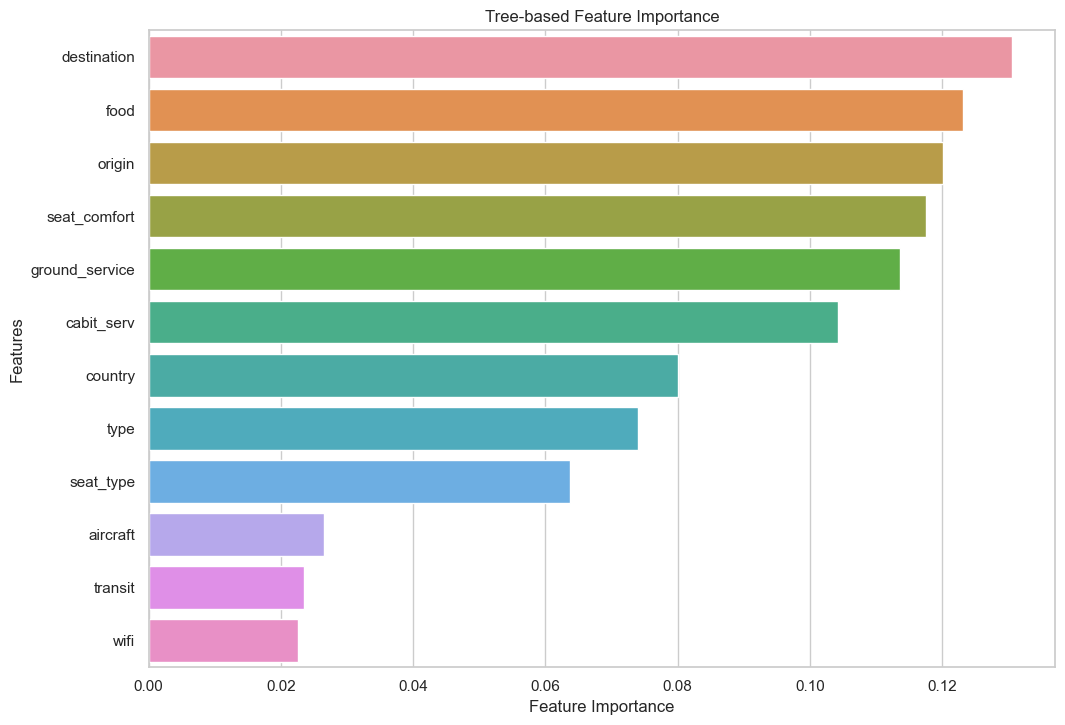

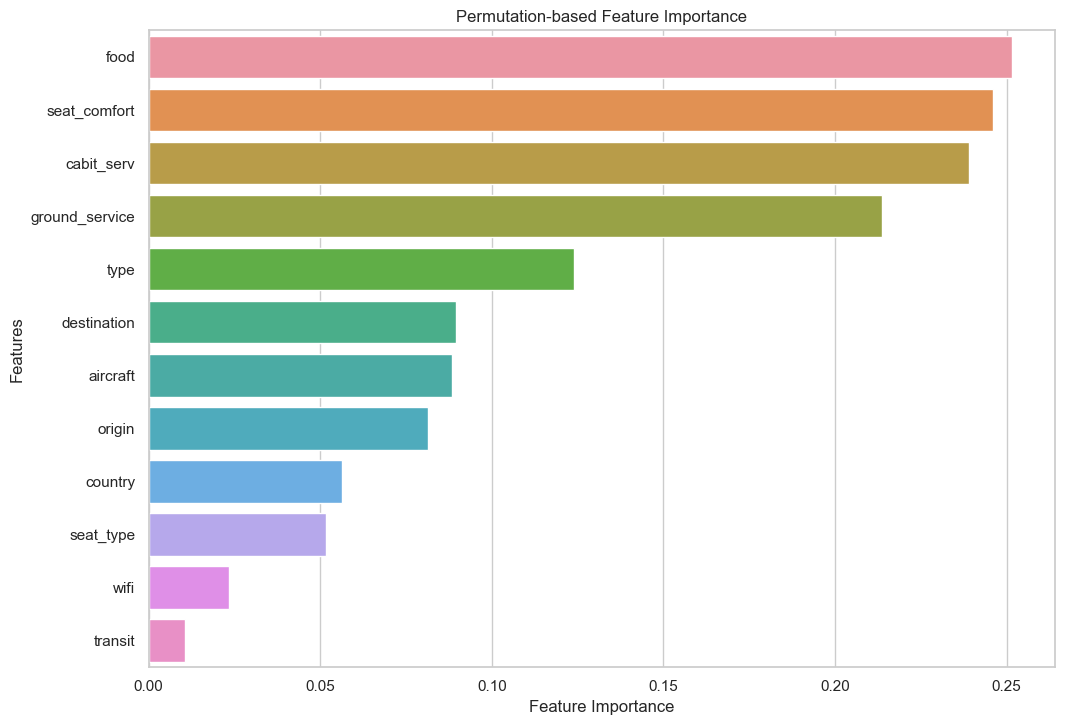

Top 3 significant features based on tree-based importance: Index(['destination', 'food', 'origin'], dtype='object')
Top 3 significant features based on permutation importance: Index(['food', 'seat_comfort', 'cabit_serv'], dtype='object')


In [33]:
# General case
X = df[explanatory_vars]
y = df['money_value']

tree_sorted_idx = calculate_tree_importance(X, y)
perm_sorted_idx = calculate_permutation_importance(X, y)

top_perm_features = X.columns[perm_sorted_idx[:3]]
top_tree_features = X.columns[tree_sorted_idx[:3]]


print("Top 3 significant features based on tree-based importance:", top_tree_features)
print("Top 3 significant features based on permutation importance:", top_perm_features)

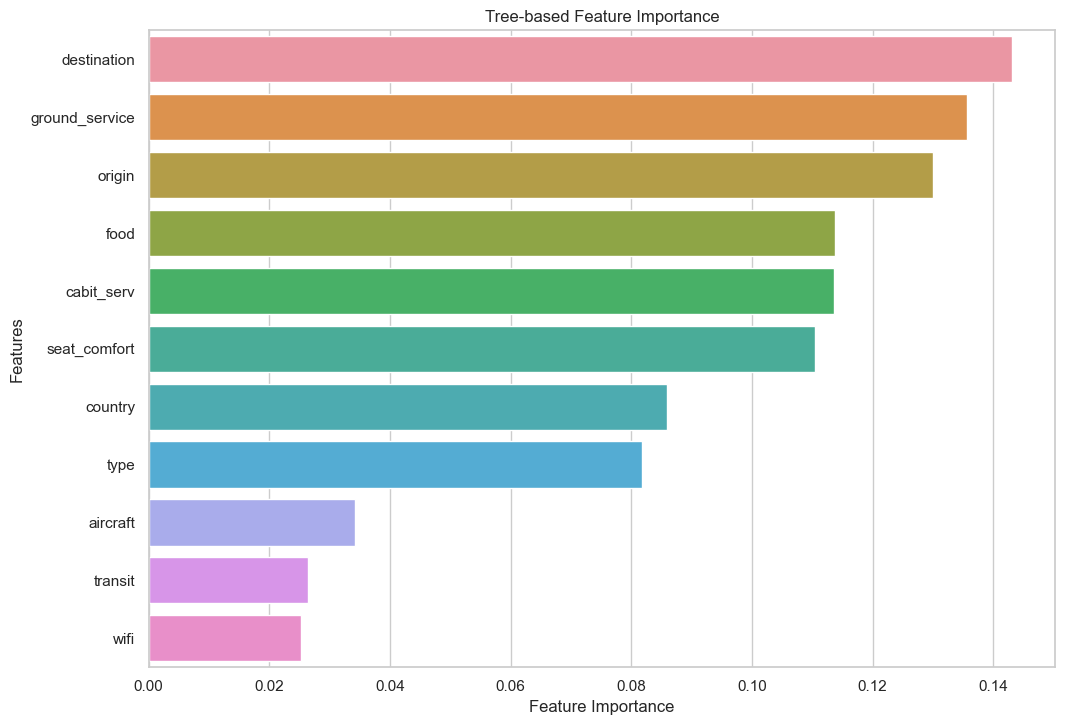

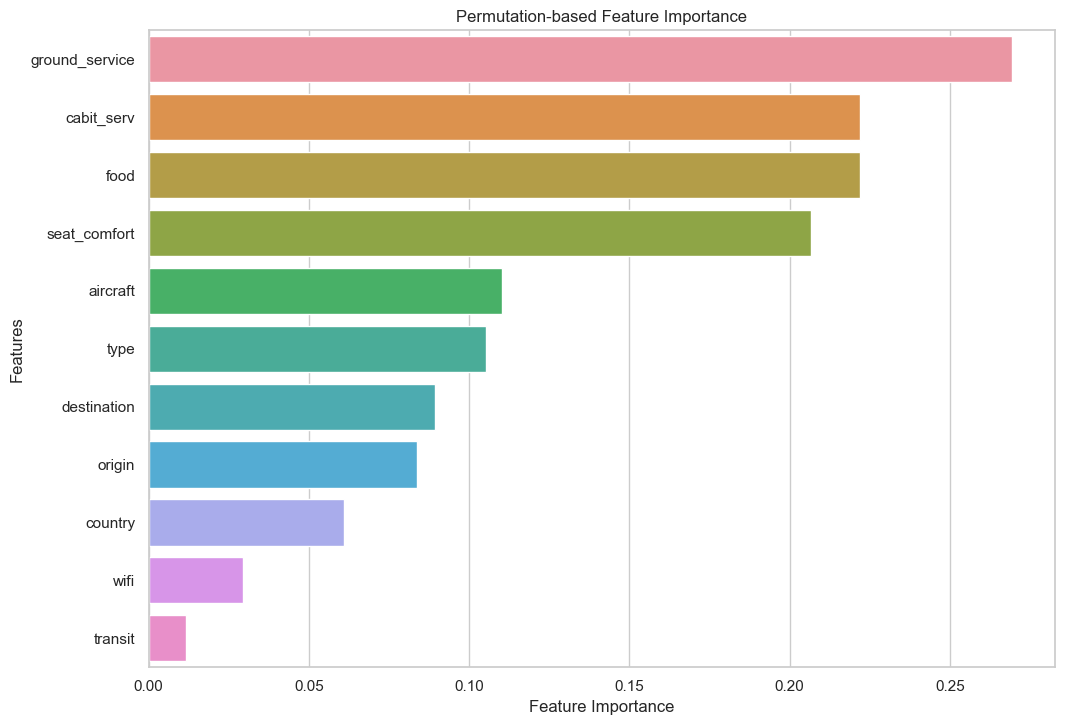

Top 3 significant features based on tree-based importance for Economy seat type: Index(['destination', 'ground_service', 'origin'], dtype='object')
Top 3 significant features based on permutation importance for Economy seat type: Index(['ground_service', 'cabit_serv', 'food'], dtype='object')


In [34]:
# Economy case
economy_class_df = df[df['seat_type'] == 1]
explanatory_vars = ['country', 'aircraft', 'type','origin', 'destination', 'transit' , 'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']

X_economy = economy_class_df[explanatory_vars]
y_economy = economy_class_df['money_value']

tree_sorted_idx_economy = calculate_tree_importance(X_economy, y_economy)
top_tree_features_economy = X_economy.columns[tree_sorted_idx_economy[:3]]
perm_sorted_idx_economy = calculate_permutation_importance(X_economy, y_economy)
top_perm_features_economy = X_economy.columns[perm_sorted_idx_economy[:3]]


print("Top 3 significant features based on tree-based importance for Economy seat type:", top_tree_features_economy)
print("Top 3 significant features based on permutation importance for Economy seat type:", top_perm_features_economy)

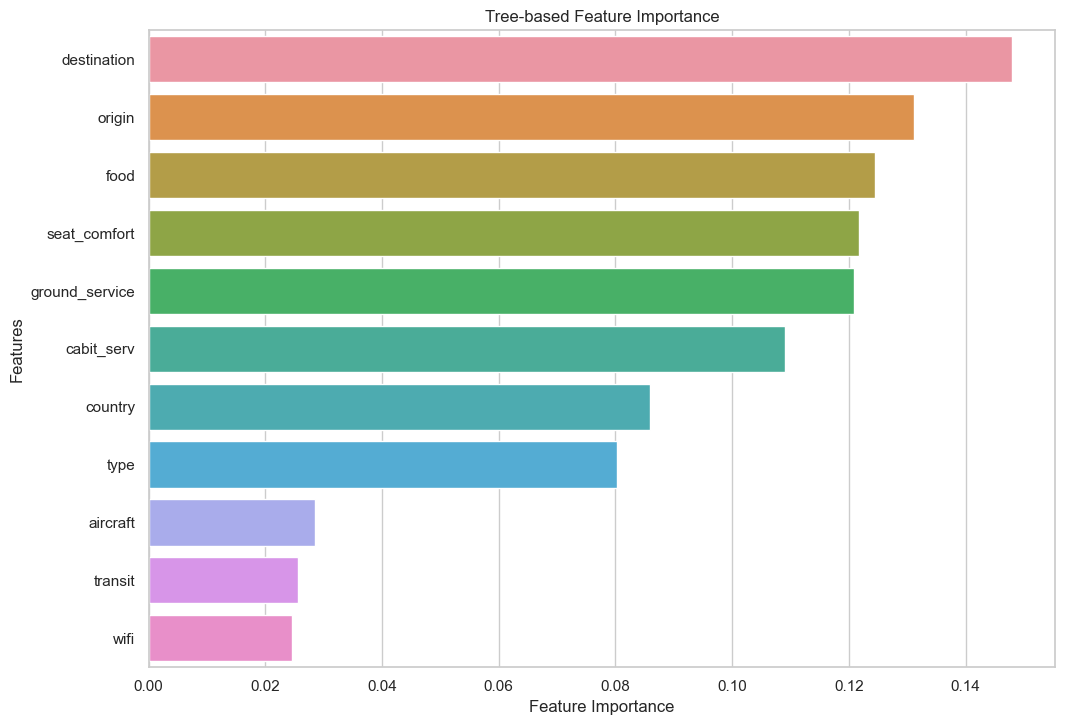

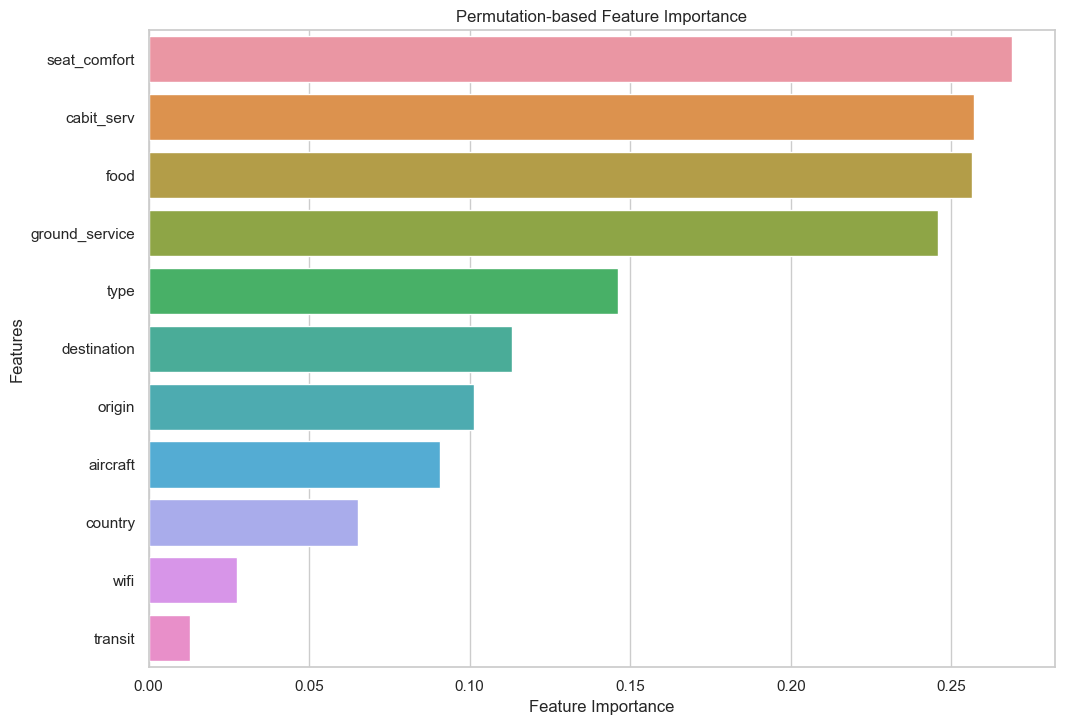

Top 3 significant features based on permutation importance for non-Economy seat type: Index(['seat_comfort', 'cabit_serv', 'food'], dtype='object')
Top 3 significant features based on tree-based importance for non-Economy seat type: Index(['destination', 'origin', 'food'], dtype='object')


In [35]:
# Non-economy case
non_economy_class_df = df[df['seat_type'] != 'Economy']
explanatory_vars = ['country', 'aircraft', 'type','origin', 'destination', 'transit' , 'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']

X_non_economy = non_economy_class_df[explanatory_vars]
y_non_economy = non_economy_class_df['money_value']

tree_sorted_idx_non_economy = calculate_tree_importance(X_non_economy, y_non_economy)
top_tree_features_non_economy = X_non_economy.columns[tree_sorted_idx_non_economy[:3]]
perm_sorted_idx_non_economy = calculate_permutation_importance(X_non_economy, y_non_economy)
top_perm_features_non_economy = X_non_economy.columns[perm_sorted_idx_non_economy[:3]]

print("Top 3 significant features based on permutation importance for non-Economy seat type:", top_perm_features_non_economy)
print("Top 3 significant features based on tree-based importance for non-Economy seat type:", top_tree_features_non_economy)